In [1]:
# AB Env and Parks does not give easy access to their real time stations.
# They only provide the last few days of hourly data
# urls for files look like this:
# http://environment.alberta.ca/apps/Basins/data/text/snow/05CA805.csv

In [2]:
%matplotlib inline
#mpld3.enable_notebook()
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr
from astropy.io import ascii
import pytz
# OS interaction
import sys
import os
import glob
import wget
import seaborn as sns
sns.set_context("talk",font_scale=1.5)
sns.set_style('whitegrid')

# User config

In [3]:
# Paths to user files
data_dir = os.path.normpath(r'F:\Work\e\Data\Obs\Canada_Project_Sites\CSAS_data') # Where to store data on local computer
git_dir  = os.path.normpath(r'C:\Users\new356\Google Drive\Python\CSAS') # This repo

In [4]:
# Stations we wish to download
sta_code = ['05AD803','13A19S','05AA809','05DB802','05BJ805','05BL811','13A27S','05BL812','05CA805','05AA817','05BB803','05BF824']
c_network = 'environmentAlberta'

# Create paths

In [5]:
# Data network
network = 'AB_recent'

# Location to download current AB station data
download_dir = os.path.join(data_dir,network,'current')
# Make if does not exist
if not os.path.exists(download_dir):
    os.makedirs(download_dir)
    
# Netcdf file to save to
netcdf_dir   = os.path.join(data_dir,network,'netcdf')
# Make if does not exist
if not os.path.exists(netcdf_dir):
    os.makedirs(netcdf_dir)
netcdf_file_out =  os.path.join(netcdf_dir,'AB_NRT.nc')

# Metadata for AB pillows 
meta_file         = 'AB_Station_Metadata.csv'
meta_file_path    = os.path.join(git_dir,'metadata',meta_file)

# Download Near-real time AB data (Updated hourly)

In [6]:
url_base = 'http://environment.alberta.ca/apps/Basins/data/text/snow/'
file_ext = '.csv'

In [7]:
os.chdir(download_dir)
Var_names = ['SWE','Snowdepth','AirTemperature','Precipitation']
AB_2_BC_var_dict = {'Snow Water Equivalent':Var_names[0],'Snow Depth':Var_names[1],'Air Temperature':Var_names[2]}
Var_units = ['mm','cm','C','mm']
unit_dict = dict(zip(Var_names,Var_units))

In [8]:
# Remove previous files
for cfile in sta_code:
    try:
        os.remove(cfile+file_ext)
    except OSError:
        pass

In [9]:
# Download newest files
for csta in sta_code:
    try:
        wget.download(url_base+csta+file_ext) 
    except OSError:
        pass

100% [............................................................] 5453 / 5453

In [10]:
# Import each data variable
ds_list = []
sta_list_used = []
for (i,csta) in enumerate(sta_code):
    cf = csta+file_ext
    print(cf)
    
    # Load in to python
    df = pd.read_csv(cf,index_col=1, skiprows=20, skipfooter=1, engine='python', parse_dates=True)
    df.index.names = ['Time_MST']
    
    # Remove units
    df = df[1:]
    
    # Rename columns
    df = df.rename(columns = AB_2_BC_var_dict)
    
    # Drop Station No.
    df = df.drop('Station No.', 1)
    
    # Force to numeric
    df = df.convert_objects(convert_numeric=True)
    
    # df to ds
    ds_c = xr.Dataset.from_dataframe(df)
    # Add as coord
    ds_c['staID'] = csta
    ds_c.set_coords('staID',inplace=True)
    
    # Store as dict (if we have any data)
    if ds_c.Time_MST.size>0:
        ds_list.append(ds_c)
        sta_list_used.append(csta)

05AD803.csv
13A19S.csv
05AA809.csv
05DB802.csv
05BJ805.csv
05BL811.csv
13A27S.csv
05BL812.csv
05CA805.csv
05AA817.csv
05BB803.csv
05BF824.csv


C:\Users\new356\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [11]:
# Merge into netcdf
ds = xr.concat(ds_list,'staID')
ds

<xarray.Dataset>
Dimensions:         (Time_MST: 107, staID: 12)
Coordinates:
  * Time_MST        (Time_MST) datetime64[ns] 2017-08-12 2017-08-12T01:00:00 ...
  * staID           (staID) <U7 '05AD803' '13A19S' '05AA809' '05DB802' ...
Data variables:
    SWE             (staID, Time_MST) float64 9.0 9.0 9.0 9.0 9.0 9.0 9.0 ...
    Snowdepth       (staID, Time_MST) float64 nan nan nan nan nan nan nan ...
    AirTemperature  (staID, Time_MST) float64 11.39 11.09 10.36 10.13 9.82 ...

In [12]:
ds.staID

<xarray.DataArray 'staID' (staID: 12)>
array(['05AD803', '13A19S', '05AA809', '05DB802', '05BJ805', '05BL811',
       '13A27S', '05BL812', '05CA805', '05AA817', '05BB803', '05BF824'], 
      dtype='<U7')
Coordinates:
  * staID    (staID) <U7 '05AD803' '13A19S' '05AA809' '05DB802' '05BJ805' ...

In [13]:
# Read in metadata provided by Stephen at AEP.DMNRT@gov.ab.ca
metadata = pd.read_csv(meta_file_path, index_col='stnnumber', encoding = "ISO-8859-1", usecols=['stnname','stnnumber','stnlatitude','stnlongitude','stnelevationmet'])
metadata.index.names = ['staID']

In [14]:
# Extract only stations we are interested in
metadata = metadata.loc[ds.staID.values]

In [15]:
## ADD UNITS
# Add variable attributes (units), and fix variable names (remove spaces)
for cvar in ds.data_vars:
    # add units as attributes
    ds.get(cvar).attrs['unit']   = unit_dict[cvar]

In [16]:
# ## Add station metadata
ds['station_name'] = xr.DataArray(metadata['stnname'],coords={'staID':metadata.index}, dims='staID')
ds['Lat'] = xr.DataArray(metadata['stnlatitude'],coords={'staID':metadata.index}, dims='staID')
ds['Lon'] = xr.DataArray(metadata['stnlongitude'],coords={'staID':metadata.index}, dims='staID')
ds['Elevation'] = xr.DataArray(metadata['stnelevationmet'],coords={'staID':metadata.index}, dims='staID')

In [17]:
ds.set_coords(['station_name','Lat','Lon','Elevation'], inplace=True)

<xarray.Dataset>
Dimensions:         (Time_MST: 107, staID: 12)
Coordinates:
  * Time_MST        (Time_MST) datetime64[ns] 2017-08-12 2017-08-12T01:00:00 ...
  * staID           (staID) object '05AD803' '13A19S' '05AA809' '05DB802' ...
    station_name    (staID) object 'Akamina Pass' ...
    Lat             (staID) float64 49.03 48.8 49.36 51.89 50.82 50.17 48.8 ...
    Lon             (staID) float64 -114.1 -113.9 -114.5 -115.4 -115.0 ...
    Elevation       (staID) float64 1.761e+03 1.92e+03 1.97e+03 1.988e+03 ...
Data variables:
    SWE             (staID, Time_MST) float64 9.0 9.0 9.0 9.0 9.0 9.0 9.0 ...
    Snowdepth       (staID, Time_MST) float64 nan nan nan nan nan nan nan ...
    AirTemperature  (staID, Time_MST) float64 11.39 11.09 10.36 10.13 9.82 ...

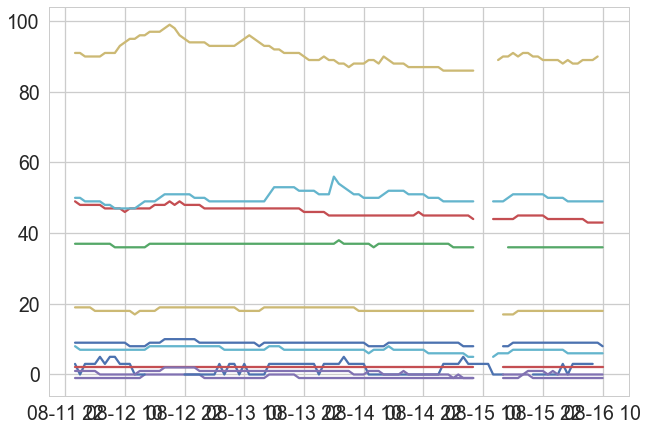

In [18]:
plt.plot(ds.Time_MST,ds.SWE.T.values);

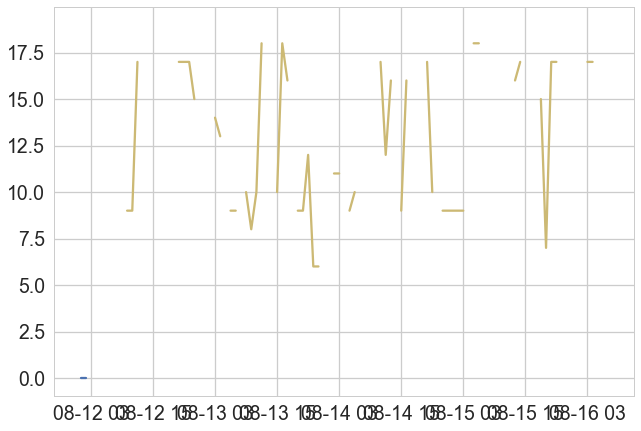

In [19]:
plt.plot(ds.Time_MST,ds.Snowdepth.T.values);

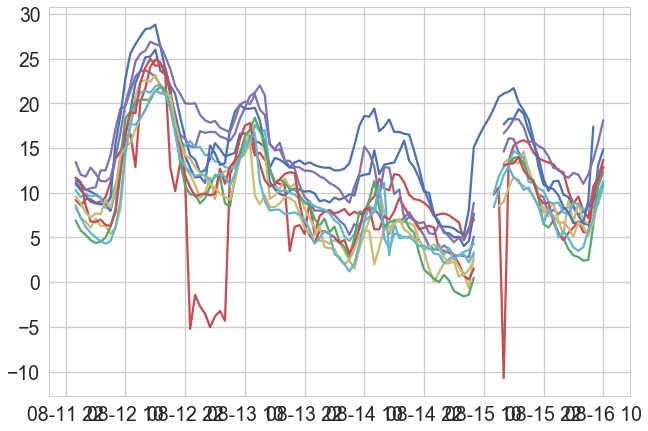

In [20]:
plt.plot(ds.Time_MST,ds.AirTemperature.T.values);

In [21]:
# Adjust time zone to UTC
# ISSUE here is that time zone is "Current" as in it changes between MDT and MST (dumb), so go with MST here as we most often care about snow during witner
# MST to UTC (-7 hours)
ds['Time_MST'] = ds.Time_MST + np.timedelta64(-7,'h')
ds.rename({'Time_MST':'Time_UTC'},inplace=True)

<xarray.Dataset>
Dimensions:         (Time_UTC: 107, staID: 12)
Coordinates:
  * Time_UTC        (Time_UTC) datetime64[ns] 2017-08-11T17:00:00 ...
  * staID           (staID) object '05AD803' '13A19S' '05AA809' '05DB802' ...
    station_name    (staID) object 'Akamina Pass' ...
    Lat             (staID) float64 49.03 48.8 49.36 51.89 50.82 50.17 48.8 ...
    Lon             (staID) float64 -114.1 -113.9 -114.5 -115.4 -115.0 ...
    Elevation       (staID) float64 1.761e+03 1.92e+03 1.97e+03 1.988e+03 ...
Data variables:
    SWE             (staID, Time_UTC) float64 9.0 9.0 9.0 9.0 9.0 9.0 9.0 ...
    Snowdepth       (staID, Time_UTC) float64 nan nan nan nan nan nan nan ...
    AirTemperature  (staID, Time_UTC) float64 11.39 11.09 10.36 10.13 9.82 ...

In [22]:
# Add Netowork
ds.coords['network'] = xr.DataArray([c_network for x in ds.staID], dims='staID')

In [23]:
# Save as netcdf file
ds.to_netcdf(netcdf_file_out)